### Imports

In [229]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
import cv2
import re
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

In [230]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image, ImageFilter
from dataclasses import dataclass

In [231]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F

### Constants

In [232]:
from displacements import VectorFieldComposer, VECTOR_FIELDS

TILES_DIR = "../tiles"
TILE_SIZE = 256

sequence_arrays = {}

# Iterate through sequence folders (e.g., "78", "g60")
for sequence_name in os.listdir(TILES_DIR):
    sequence_path = os.path.join(TILES_DIR, sequence_name)

    if os.path.isdir(sequence_path):  # Ignore hidden files/folders
        tile_arrays = {}  # Dictionary for tile arrays within this sequence

        # Iterate through image folders within the sequence (e.g., "0001.tif", "0023.tif")
        for image_folder_name in os.listdir(sequence_path):
            image_folder_path = os.path.join(sequence_path, image_folder_name)

            if os.path.isdir(image_folder_path):
                # Iterate through the tile images within the image folder
                for tile_image_name in os.listdir(image_folder_path):
                    if tile_image_name.startswith("tile_") and tile_image_name.endswith(".png"):
                        try:
                            tile_number_match = re.search(r"tile_(\d+)\.png", tile_image_name)
                            if tile_number_match:
                                tile_number = int(tile_number_match.group(1))
                                tile_image_path = os.path.join(image_folder_path, tile_image_name)
                                if tile_number not in tile_arrays:
                                    tile_arrays[tile_number] = []
                                tile_arrays[tile_number].append(tile_image_path)

                        except ValueError:
                            print(f"Warning: Could not parse tile number from {tile_image_name} in {image_folder_path}")



        sequence_arrays[sequence_name] = tile_arrays  # Add the tile arrays for this sequence


# Model

In [233]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Convolution Model

In [234]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

### Warping Model

In [235]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        return self.conv(x) + self.residual(x)


class CorrelationLayer(nn.Module):
    def __init__(self, patch_size=1, kernel_size=1, stride=1, padding=0, max_displacement=20):
        super().__init__()
        self.patch_size = patch_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.max_displacement = max_displacement

    def forward(self, feature_map_1, feature_map_2):
        """
        Args:
            feature_map_1: Feature map from image 1 (N, C, H, W)
            feature_map_2: Feature map from image 2 (N, C, H, W)

        Returns:
            correlation_volume: Correlation volume (N, 1, H, W, (2*max_displacement+1)**2)
        """
        batch_size, channels, height, width = feature_map_1.size()

        # Pad feature_map_2 to handle displacements
        padding_size = self.max_displacement
        feature_map_2_padded = F.pad(feature_map_2, (padding_size, padding_size, padding_size, padding_size))

        correlation_volume_list = []

        # loop over all possible displacements within max_displacement
        for displacement_y in range(-self.max_displacement, self.max_displacement + 1):
            for displacement_x in range(-self.max_displacement, self.max_displacement + 1):
                # Shift feature_map_2
                shifted_feature_map_2 = feature_map_2_padded[
                    :, :, padding_size + displacement_y : padding_size + displacement_y + height, padding_size + displacement_x : padding_size + displacement_x + width
                ]

                # now we compute correlation and reshape for correlation volume
                correlation_map = (feature_map_1 * shifted_feature_map_2).sum(dim=1, keepdim=True)  # Sum over channels
                correlation_volume_list.append(correlation_map)

        # put them all together
        correlation_volume = torch.cat(correlation_volume_list, dim=1)  # N, (2*max_displacement+1)**2, H, W
        correlation_volume = correlation_volume.permute(0, 2, 3, 1).unsqueeze(1)  # N, 1, H, W, (2*max_displacement+1)**2 - reshape to match expected output

        return correlation_volume


class MotionVectorRegressionNetworkWithCorrelation(nn.Module):
    def __init__(self, input_images=2, max_displacement=20):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2
        self.max_displacement = max_displacement  # Store max_displacement

        self.feature_convolution = nn.Sequential(
            ConvolutionBlock(1, 32, kernel_size=3),  # input_images (1) -> 32 channels
            nn.MaxPool2d(kernel_size=2),  # scales down by half
            ConvolutionBlock(32, 64, kernel_size=3),  # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2),  # scales down by half
            ConvolutionBlock(64, 128, kernel_size=3),  # 64 -> 128 channels
            # ConvolutionBlock(64, 128, kernel_size=3),
        )

        self.correlation_layer = CorrelationLayer(max_displacement=self.max_displacement)  # Correlation Layer

        self.convolution_after_correlation = nn.Sequential(  # Convolution layers after correlation
            ConvolutionBlock(128 + (2 * max_displacement + 1) ** 2, 128, kernel_size=3),
            ConvolutionBlock(128, 128, kernel_size=3),  # 128 -> 128 channels
        )

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1),  # 32 -> 2 channels
        )

    def forward(self, x):
        # split input into image 1 and image 2
        image1 = x[:, 0:1, :, :]
        image2 = x[:, 1:2, :, :]

        features1 = self.feature_convolution(image1)
        features2 = self.feature_convolution(image2)

        # Correlation layer
        correlation_volume = self.correlation_layer(features1, features2)  # N, 1, H, W, (2*max_displacement+1)**2

        # concatenate correlation volume with features1 (you can experiment with features2 or concatenation strategy)
        # reshape correlation volume to (N, C, H, W) where C = (2*max_displacement+1)**2
        correlation_volume_reshaped = correlation_volume.squeeze(1).permute(0, 3, 1, 2)  # N, (2*max_displacement+1)**2, H, W
        combined_features = torch.cat((features1, correlation_volume_reshaped), dim=1)  # Concatenate along channel dimension

        x = self.convolution_after_correlation(combined_features)
        x = self.output(x)  # output layers
        return x

class MotionVectorRegressionNetworkWithWarping(nn.Module): # Model 3: Model 1 + Warping (2-Stage Stacked)
    def __init__(self, input_images=2, max_displacement=20):
        super().__init__()
        self.input_images = input_images
        self.max_displacement = max_displacement

        self.stage1_model = MotionVectorRegressionNetworkWithCorrelation(input_images=input_images, max_displacement=self.max_displacement)
        self.stage2_model = MotionVectorRegressionNetworkWithCorrelation(input_images=input_images, max_displacement=self.max_displacement) # Stage 2 model - same architecture as stage 1


    def forward(self, x):
        # Split input into image 1 and image 2
        image1 = x[:, 0:1, :, :] # Assuming grayscale input, adjust if RGB
        image2 = x[:, 1:2, :, :]

        # Stage 1: Predict flow1
        flow1 = self.stage1_model(x) # Input is the original image pair

        # Warping layer: Warp image2 using flow1
        # Create grid for warping
        batch_size, _, height, width = image1.size()
        grid = self._create_meshgrid(batch_size, height, width, device=x.device)

        # Normalize flow to grid scale (-1 to 1) - Important for F.grid_sample
        flow1_normalized_x = flow1[:, 0, :, :] / (width / 2)
        flow1_normalized_y = flow1[:, 1, :, :] / (height / 2)
        flow1_normalized = torch.stack((flow1_normalized_x, flow1_normalized_y), dim=1) # N, 2, H, W
        flow1_normalized = flow1_normalized.permute(0, 2, 3, 1) # N, H, W, 2 - channels last for grid_sample

        warped_image2_1 = F.grid_sample(image2, grid + flow1_normalized, mode='bilinear', padding_mode='zeros', align_corners=False)


        # Stage 2: Predict flow2 (residual flow) - Input is image1 and warped_image2_1
        stage2_input = torch.cat((image1, warped_image2_1), dim=1) # Concatenate image1 and warped_image2_1 for stage 2 input
        flow2 = self.stage2_model(stage2_input) # Model 2 predicts residual flow


        # Combine flows: Simple additive combination for now
        final_flow = flow1 + flow2 # Add flow2 (residual) to flow1

        return final_flow


    def _create_meshgrid(self, batch_size, height, width, device): # Helper function for meshgrid
        x_grid = torch.linspace(-1.0, 1.0, width, device=device)
        y_grid = torch.linspace(-1.0, 1.0, height, device=device)

        x_mesh, y_mesh = torch.meshgrid(x_grid, y_grid, indexing='ij') # Use indexing='ij' for consistent xy ordering

        # Stack and repeat for batch size
        meshgrid = torch.stack((x_mesh, y_mesh), dim=0).float() # 2, H, W
        meshgrid = meshgrid.unsqueeze(0).repeat(batch_size, 1, 1, 1) # N, 2, H, W
        return meshgrid.permute(0, 2, 3, 1) # N, H, W, 2 - channels last for grid_sample


In [236]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.q_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.k_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.v_conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.o_conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scale parameter

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.q_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # [B, N, C'] N=H*W, C'=C//8
        key = self.k_conv(x).view(batch_size, -1, width * height)  # [B, C', N]
        value = self.v_conv(x).view(batch_size, -1, width * height)  # [B, C, N]

        attention = torch.bmm(query, key)  # [B, N, N]
        attention = torch.softmax(attention, dim=-1)

        attention_value = torch.bmm(value, attention)  # [B, C, N]
        attention_value = attention_value.view(batch_size, channels, height, width)  # [B, C, H, W]

        output = self.o_conv(attention_value)
        return self.gamma * output + x  # Residual connection with learnable scale

        
class ComboMotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images=2, base_channels=64, num_conv_blocks=3):
        super().__init__()
        self.input_images = input_images
        self.vector_channels = 2
        channels = base_channels

        # Downsampling path (No changes needed)
        self.conv1 = ConvolutionBlock(input_images, channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = ConvolutionBlock(channels, channels * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        conv_blocks = []
        current_channels = channels * 2
        feature_channels = [channels, channels * 2]
        down_feature_channel_sizes = []
        for _ in range(num_conv_blocks):
            channels *= 2
            down_feature_channel_sizes.append(current_channels)
            conv_blocks.extend(
                [
                    ConvolutionBlock(current_channels, channels, kernel_size=3),
                    ConvolutionBlock(channels, channels, kernel_size=3),
                    nn.MaxPool2d(kernel_size=2),
                ]
            )
            current_channels = channels
            feature_channels.append(channels)
        self.conv_layers_down = nn.Sequential(*conv_blocks[:-1])
        down_feature_channel_sizes.append(current_channels)

        # Bottleneck with Attention (No changes needed)
        self.attention = SelfAttention(channels)

        # Upsampling path (Corrected in Attempt 4)
        up_channels = channels  # up_channels = 512
        self.upconv1 = nn.ConvTranspose2d(up_channels, up_channels // 2, kernel_size=4, stride=2, padding=1)  # 512 -> 256
        self.conv_up1 = ConvolutionBlock(up_channels // 2 + down_feature_channel_sizes[-2], up_channels // 2)  # Input: 512, Output: 256

        up_channels = 256  # Reset up_channels to output of conv_up1 = 256
        self.upconv2 = nn.ConvTranspose2d(up_channels, up_channels // 2, kernel_size=4, stride=2, padding=1)  # Revised: 256 -> 128
        self.conv_up2 = ConvolutionBlock(up_channels // 2 + down_feature_channel_sizes[-3], up_channels // 2)  # Revised Input: 384, Output: 128

        up_channels //= 2  # up_channels = 128
        self.upconv3 = nn.ConvTranspose2d(up_channels, up_channels // 2, kernel_size=4, stride=2, padding=1)  # Revised: 128 -> 64
        self.conv_up3 = ConvolutionBlock(up_channels // 2 + feature_channels[1], up_channels // 2)  # Revised Input: 192, Output: 64

        up_channels //= 2  # up_channels = 64
        self.upconv4 = nn.ConvTranspose2d(up_channels, up_channels // 2, kernel_size=4, stride=2, padding=1)  # Revised: 64 -> 32
        self.conv_up4 = ConvolutionBlock(up_channels // 2 + feature_channels[0], up_channels // 2)  # Revised Input: 96, Output: 32

        up_channels //= 2  # up_channels = 32
        self.output_conv = nn.Conv2d(up_channels, self.vector_channels, kernel_size=3, stride=1, padding=1)  # Revised: Input 32 -> Output 2

    def forward(self, x):
        # Downsampling
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv_down = pool2
        intermediate_features = [conv1, conv2]
        down_features_to_concat = []

        # Deeper Downsampling
        for i, layer in enumerate(self.conv_layers_down):
            conv_down = layer(conv_down)
            if isinstance(layer, ConvolutionBlock) and (i + 1) % 3 == 1:
                down_features_to_concat.append(conv_down)

        conv_bottleNeck = self.attention(conv_down)

        # Upsampling
        upconv1 = self.upconv1(conv_bottleNeck)
        upconv1_concat = torch.cat([upconv1, down_features_to_concat[-2]], dim=1)  # Corrected index
        conv_up1 = self.conv_up1(upconv1_concat)

        upconv2 = self.upconv2(conv_up1)
        upconv2_concat = torch.cat([upconv2, down_features_to_concat[-3]], dim=1)  # Corrected index
        conv_up2 = self.conv_up2(upconv2_concat)

        upconv3 = self.upconv3(conv_up2)
        upconv3_concat = torch.cat([upconv3, intermediate_features[1]], dim=1)
        conv_up3 = self.conv_up3(upconv3_concat)

        upconv4 = self.upconv4(conv_up3)
        upconv4_concat = torch.cat([upconv4, intermediate_features[0]], dim=1)
        conv_up4 = self.conv_up4(upconv4_concat)

        output = self.output_conv(conv_up4)
        return output

# Testing

In [ ]:
# testin gthe model

MODEL_FILE = "model_files/batch-m4-combo.pth"

# model = MotionVectorRegressionNetwork().to(device)
# model = MotionVectorRegressionNetworkWithWarping().to(device)


<All keys matched successfully>

In [238]:
@dataclass
class Tile:
    data: np.ndarray
    position: Tuple[int, int]  # (y, x) position in original image
    size: int
    overlap: int

In [239]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tiles(image1_tiles, image2_tiles, output_tiles, original_shape, 
               title1="Image 1 Tiles", title2="Image 2 Tiles", title_out="Output Tiles"):
    """Plots input tiles from two images and output tiles in a grid layout."""

    height, width = original_shape[:2]
    tile_size = image1_tiles[0].size
    overlap = image1_tiles[0].overlap

    # Compute number of rows and cols based on tiling logic
    num_cols = (width - overlap) // (tile_size - overlap) + 1
    num_rows = (height - overlap) // (tile_size - overlap) + 1

    fig, axes = plt.subplots(3, num_rows * num_cols, figsize=(15, 9))

    for i, (tile1, tile2, tile_out) in enumerate(zip(image1_tiles, image2_tiles, output_tiles)):
        # Convert grayscale to RGB if needed
        img1 = tile1.data if tile1.data.shape[-1] == 3 else np.stack([tile1.data]*3, axis=-1)
        img2 = tile2.data if tile2.data.shape[-1] == 3 else np.stack([tile2.data]*3, axis=-1)
        img_out = tile_out.data if tile_out.data.shape[-1] == 3 else np.stack([tile_out.data]*3, axis=-1)

        # Normalize output tile if it's not in the 0-255 range
        img_out = np.clip(img_out, 0, 255).astype(np.uint8)

        # Plot first input image tiles
        axes[0, i].imshow(img1)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"{title1} {i+1}")

        # Plot second input image tiles
        axes[1, i].imshow(img2)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"{title2} {i+1}")

        # Plot output image tiles
        axes[2, i].imshow(img_out)
        axes[2, i].axis("off")
        axes[2, i].set_title(f"{title_out} {i+1}")

    plt.tight_layout()
    plt.show()



In [240]:
size: int = 256
overlap: int = 32
def create_tiles(image: np.ndarray) -> List[Tile]:
    """Split image into overlapping tiles."""
    height, width = image.shape
    tiles = []

    for y in range(0, height, size - overlap):
        for x in range(0, width, size - overlap):

            # Calculate tile boundaries
            y_end = min(y + size, height)
            x_end = min(x + size, width)
            
            # Extract tile data
            tile_data = image[y:y_end, x:x_end]
            
            # Pad if necessary
            if tile_data.shape != (size, size):
                padded_data = np.zeros((size, size), dtype=tile_data.dtype)
                padded_data[:tile_data.shape[0], :tile_data.shape[1]] = tile_data
                tile_data = padded_data
            
            tiles.append(Tile(
                data=tile_data,
                position=(y, x),
                size=size,
                overlap=overlap
            ))
            
    return tiles

In [267]:
def stitch_tiles_f(tiles: List[Tile], original_shape: tuple) -> np.ndarray:
    """Stitch tiles back together with average blending in overlap regions for colored images."""
    height, width = original_shape
    shape_with_channels = (height, width, 3)
    result = np.zeros(shape_with_channels, dtype=np.float32)
    weights = np.zeros((height, width, 1), dtype=np.float32)  # Single-channel weight map

    for tile in tiles:
        y, x = tile.position
        y_end = min(y + tile.size, height)
        x_end = min(x + tile.size, width)
        
        # Create weight mask for smooth blending
        weight_mask = np.ones((y_end - y, x_end - x, 1), dtype=np.float32)
        
        # Apply feathering at edges
        if tile.overlap > 0:
            # Feather left edge
            if x > 0:
                weight_mask[:, :tile.overlap, :] *= np.linspace(0, 1, tile.overlap).reshape(1, -1, 1)
            # Feather right edge
            if x_end < width:
                weight_mask[:, -tile.overlap:, :] *= np.linspace(1, 0, tile.overlap).reshape(1, -1, 1)
            # Feather top edge
            if y > 0:
                weight_mask[:tile.overlap, :, :] *= np.linspace(0, 1, tile.overlap).reshape(-1, 1, 1)
            # Feather bottom edge
            if y_end < height:
                weight_mask[-tile.overlap:, :, :] *= np.linspace(1, 0, tile.overlap).reshape(-1, 1, 1)
            
            # Ensure even the first tile (0,0) is blended by using a small weight instead of 1
            if x == 0:
                weight_mask[:, :tile.overlap, :] *= np.linspace(0.5, 1, tile.overlap).reshape(1, -1, 1)
            if y == 0:
                weight_mask[:tile.overlap, :, :] *= np.linspace(0.5, 1, tile.overlap).reshape(-1, 1, 1)


        # Add weighted tile data
        result[y:y_end, x:x_end, :] += tile.data[:y_end-y, :x_end-x, :] * weight_mask
        weights[y:y_end, x:x_end, :] += weight_mask
    
    # **Fix: Normalize result safely using broadcasting**
    weights = np.where(weights == 0, 1, weights)  # Use np.where to avoid modifying the original weight structure
    result /= weights  # Broadcasting automatically applies normalization to all channels

    return result

def stitch_tiles(tiles: List[Tile], original_shape: tuple) -> np.ndarray:
    result = stitch_tiles_f(tiles, original_shape)
    return np.clip(result, 0, 255).astype(np.uint8)

(943, 1024)


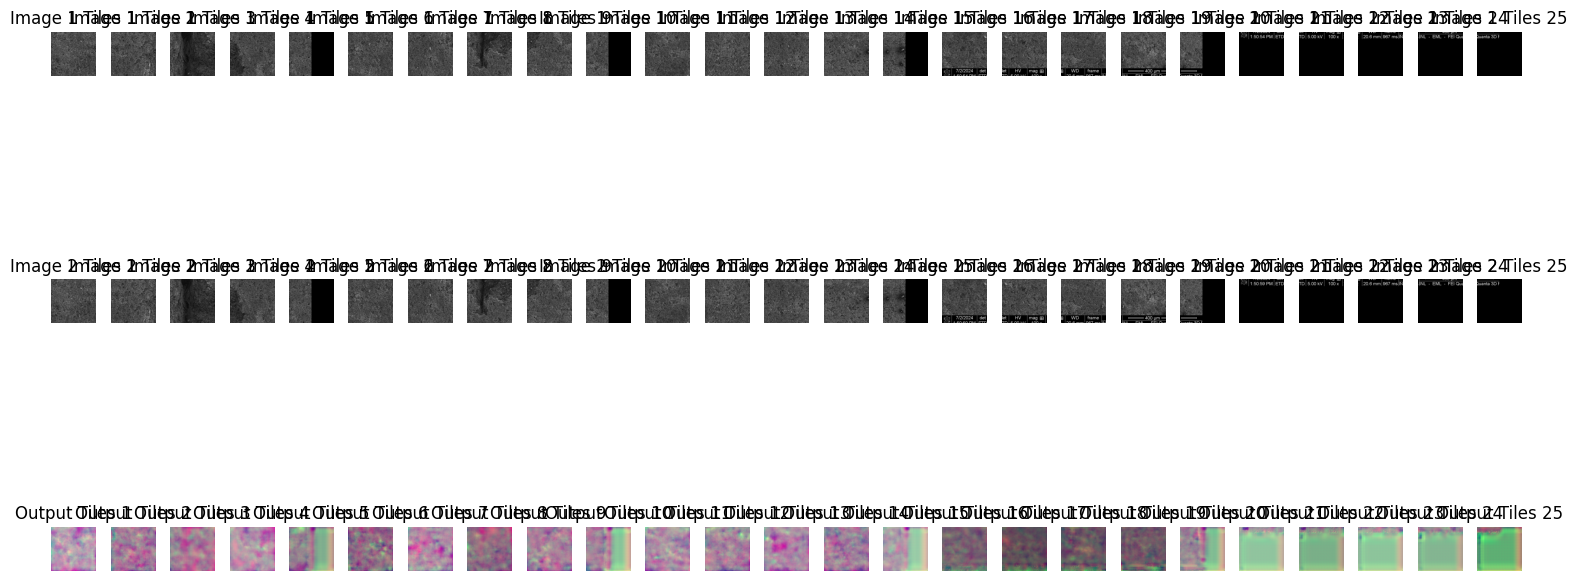

(943, 1024, 3)
[[[149 222 177]
  [165 185 177]
  [171 151 177]
  ...
  [148  70 142]
  [160  67 142]
  [137  65 142]]

 [[202 168 177]
  [176 189 177]
  [179 186 177]
  ...
  [149  90 142]
  [133  77 142]
  [141  76 142]]

 [[177 159 177]
  [169 163 177]
  [164 156 177]
  ...
  [149 107 142]
  [143  98 142]
  [139  87 142]]

 ...

 [[161 176 158]
  [151 166 158]
  [148 172 158]
  ...
  [110 167 115]
  [117 178 115]
  [111 176 115]]

 [[156 174 158]
  [145 163 158]
  [144 169 158]
  ...
  [105 174 115]
  [109 185 115]
  [110 180 115]]

 [[162 178 158]
  [152 163 158]
  [146 173 158]
  ...
  [110 173 115]
  [117 181 115]
  [112 178 115]]]
(943, 1024, 3)
(943, 1024, 3)


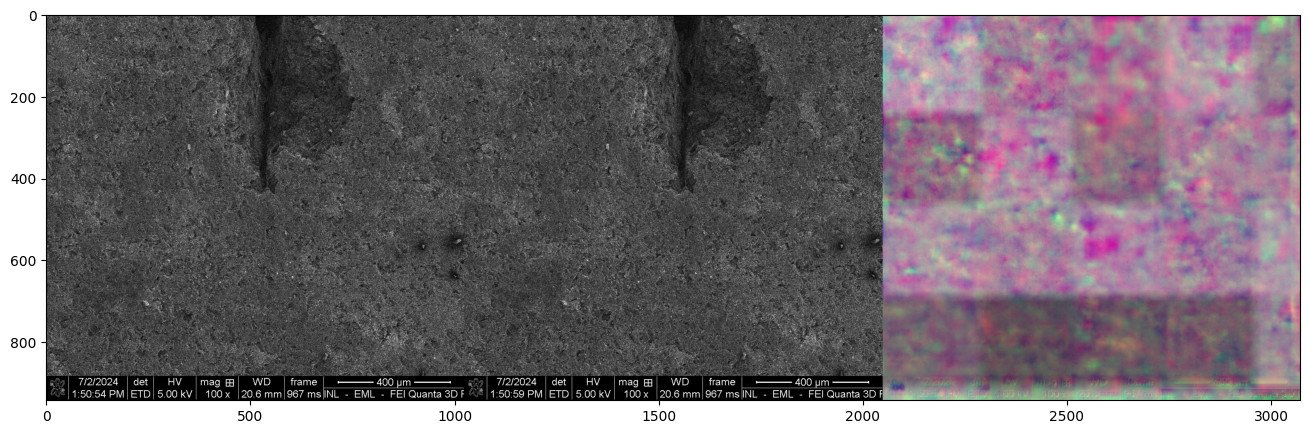

In [242]:
model.eval()

# print(sequence_arrays)
# sequence_array[sequence_name][tile index][time index]

sequence_name = 'g56'
mum_tiles = 41
# frames = [72, 73]
# num_tiles = len(sequence_arrays[sequence_name].keys())

# base_image_path = sequence_arrays['g78'][11][72]
# next_time_path = sequence_arrays['g78'][11][73]
RAW_DIR = "../raw"

image1_path = os.path.join(RAW_DIR, sequence_name, "00073.tif")
image2_path = os.path.join(RAW_DIR, sequence_name, "00074.tif")

# # '../tiles\\g78\\00074.tif\\tile_0.png'
# image1_tile_paths = glob.glob(os.path.join(TILES_DIR, sequence_name, "00073.tif", "*.png"))
# image2_tile_paths = glob.glob(os.path.join(TILES_DIR, sequence_name, "00074.tif", "*.png"))

# image1_tiles = np.stack([np.array(Image.open(tile_path), dtype=np.uint8) for tile_path in image1_tile_paths], axis=0)
# image2_tiles = np.stack([np.array(Image.open(tile_path), dtype=np.uint8) for tile_path in image2_tile_paths], axis=0)

# image_pairs = np.stack([image1_tiles, image2_tiles], axis=1)

# print(image_pairs.shape)

# image_pairs = torch.from_numpy(image_pairs).float().to(device)

# predictions = model(image_pairs)

# print(predictions.shape)

image1 = np.array(Image.open(image1_path), dtype=np.uint8)
image2 = np.array(Image.open(image2_path), dtype=np.uint8)

print(image1.shape)

image1_tiles = create_tiles(image1)
image2_tiles = create_tiles(image2)

out_tiles = []
with torch.no_grad():
    for tile1, tile2 in zip(image1_tiles, image2_tiles):
        tile_position = tile1.position
        
        stacked = np.stack([tile1.data, tile2.data], axis=0)
        # print(stacked.shape)

        batch = torch.from_numpy(np.array([stacked])).float().to(device)
        pred = model(batch)
        # print(batch.shape)
        # print(pred.shape)

        converted_pred = pred[0].cpu().numpy()
        converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
        converted_pred = np.transpose(converted_pred, (1, 2, 0))
        converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min()) * 255

        out_tiles.append(Tile(data=converted_pred, position=tile1.position, size=tile1.size, overlap=tile1.overlap))

out_stiched = stitch_tiles(out_tiles, image1.shape)
plot_tiles(image1_tiles, image2_tiles, out_tiles, image1.shape)


print(out_stiched.shape)

image1 = np.array((image1,) * 3)
image1 = np.transpose(image1, (1, 2, 0))
image2 = np.array((image2,) * 3)
image2 = np.transpose(image2, (1, 2, 0))

print(out_stiched)
print(image1.shape)
print(image2.shape)

combined = np.hstack((image1, image2, out_stiched)).astype(np.uint8)

plt.figure(figsize=(20, 5))
plt.imshow(combined)
plt.show()

# base_image = np.array(Image.open(base_image_path))
# next_time = np.array(Image.open(next_time_path))

# with torch.no_grad():
#     X = torch.from_numpy(np.array([base_image, next_time])).float()
#     X = X.unsqueeze(0)
#     X = X.to(device)
#     pred = model(X)
    
#     converted_pred = pred[0].cpu().numpy()
#     converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
#     converted_pred = np.transpose(converted_pred, (1, 2, 0))
#     converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

#     base_image = np.array((X[0, 0].cpu().numpy(),)*3)
#     base_image = np.transpose(base_image, (1, 2, 0))
#     next_time = np.array((X[0, 1].cpu().numpy(),)*3)
#     next_time = np.transpose(next_time, (1, 2, 0))
#     combined = np.hstack((base_image, next_time, converted_pred * 256)).astype(np.uint8)

#     print(combined.min(),combined.max())

#     plt.figure(figsize=(20, 5))
#     plt.imshow(combined)
#     plt.show()

In [262]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

def process_frame_pair(frame1_num, frame2_num, sequence_name, raw_dir, model, device):
    # Load consecutive frames
    image1_path = os.path.join(raw_dir, sequence_name, f"{frame1_num:05d}.tif")
    image2_path = os.path.join(raw_dir, sequence_name, f"{frame2_num:05d}.tif")
    
    image1 = np.array(Image.open(image1_path), dtype=np.uint8)
    image2 = np.array(Image.open(image2_path), dtype=np.uint8)
    
    image1_tiles = create_tiles(image1)
    image2_tiles = create_tiles(image2)
    
    out_tiles = []
    
    with torch.no_grad():
        for tile1, tile2 in zip(image1_tiles, image2_tiles):
            tile_position = tile1.position
            
            stacked = np.stack([tile1.data, tile2.data], axis=0)
            # print(stacked.shape)

            batch = torch.from_numpy(np.array([stacked])).float().to(device)
            pred = model(batch)
            # print(batch.shape)
            # print(pred.shape)

            converted_pred = pred[0].cpu().numpy()
            converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
            converted_pred = np.transpose(converted_pred, (1, 2, 0))
            # converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min()) * 255
            converted_pred = (converted_pred + 1) / 2 * 255

            out_tiles.append(Tile(data=converted_pred, position=tile1.position, size=tile1.size, overlap=tile1.overlap))
    
    out_stiched = stitch_tiles(out_tiles, image1.shape)

    image1 = np.array((image1,) * 3)
    image1 = np.transpose(image1, (1, 2, 0))
    image2 = np.array((image2,) * 3)
    image2 = np.transpose(image2, (1, 2, 0))

    combined = np.hstack((image1, image2, out_stiched)).astype(np.uint8)
    return combined

def animate_sequence(model, sequence_name, start_frame=35, end_frame=76, raw_dir="../raw", device='cuda'):
    model.eval()
    
    fig, ax = plt.subplots(figsize=(20, 5))
    
    def update(frame):
        ax.clear()
        combined = process_frame_pair(frame, frame+1, sequence_name, raw_dir, model, device)
        ax.imshow(combined)
        ax.set_title(f'Frame {frame} -> {frame+1}')
        ax.axis('off')
    
    anim = FuncAnimation(fig, update, frames=range(start_frame, end_frame),
                        interval=200, repeat=True)
    
    # Save animation
    anim.save(f'model_prediction_{sequence_name}.gif', writer='pillow')
    plt.close()

# Run the animation
seq = {
    'g56': (1, 99),
    'g64': (1, 38),
    'g66': (1, 72),
    'g69': (35, 92),
    'g71': (1, 56),
    'g78': (1, 76),
    'g79': (1, 59),
    'v83': (1, 262),
}
# sequence_name = 'g64'
# animate_sequence(model, sequence_name, start_frame=1, end_frame=2)

for sequence_name, frame_range in seq.items():
    animate_sequence(model, sequence_name, start_frame=frame_range[0], end_frame=frame_range[1])

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

def process_frame_pair(frame1_num, frame2_num, sequence_name, raw_dir, model, device, output_dir):
    """Processes two consecutive frames through the model and saves outputs."""
    
    # Load consecutive frames
    image1_path = os.path.join(raw_dir, sequence_name, f"{frame1_num:05d}.tif")
    image2_path = os.path.join(raw_dir, sequence_name, f"{frame2_num:05d}.tif")
    
    image1 = np.array(Image.open(image1_path), dtype=np.uint8)
    image2 = np.array(Image.open(image2_path), dtype=np.uint8)
    
    image1_tiles = create_tiles(image1)
    image2_tiles = create_tiles(image2)
    
    out_tiles = []
    
    with torch.no_grad():
        for tile1, tile2 in zip(image1_tiles, image2_tiles):
            tile_position = tile1.position
            
            stacked = np.stack([tile1.data, tile2.data], axis=0)
            
            batch = torch.from_numpy(np.array([stacked])).float().to(device)
            pred = model(batch)

            # Convert prediction to numpy
            converted_pred = pred[0].cpu().numpy()
            
            # Separate DX, DY components (first two channels)
            dx = converted_pred[0]  # Horizontal displacement
            dy = converted_pred[1]  # Vertical displacement

            converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
            converted_pred = np.transpose(converted_pred, (1, 2, 0))
            
            out_tiles.append(Tile(data=converted_pred, position=tile1.position, size=tile1.size, overlap=tile1.overlap))
    
    # Stitch tiles back together
    out_stitched = stitch_tiles_f(out_tiles, image1.shape)
    
    # Create model output directory
    os.makedirs(output_dir, exist_ok=True)

    # Save DX and DY as .npy
    dx_path = os.path.join(output_dir, f"{frame1_num:05d}_dx.npy")
    dy_path = os.path.join(output_dir, f"{frame1_num:05d}_dy.npy")
    
    np.save(dx_path, dx.astype(np.float32))
    np.save(dy_path, dy.astype(np.float32))

    return out_stitched

def animate_sequence(model, sequence_name, start_frame=35, end_frame=76, raw_dir="../raw", output_dir="model_outputs", device='cuda'):
    """Processes a sequence of frames through the model and saves outputs."""
    
    model.eval()
    sequence_dir = os.path.join(output_dir, sequence_name)
    os.makedirs(sequence_dir, exist_ok=True)

    stitched_frames = []  # Store stitched images for final PNG
    fig, ax = plt.subplots(figsize=(5, 5))

    def update(frame):
        ax.clear()
        out_stitched = process_frame_pair(frame, frame+1, sequence_name, raw_dir, model, device, sequence_dir)
        out_stitched = (out_stitched + 1) / 2 * 255
        out_stitched = np.clip(out_stitched, 0, 255).astype(np.uint8)
        stitched_frames.append(out_stitched)
        ax.imshow(out_stitched)
        ax.set_title(f'Frame {frame} -> {frame+1}')
        ax.axis('off')

    anim = FuncAnimation(fig, update, frames=range(start_frame, end_frame), interval=200, repeat=True)

    # Save animation
    gif_path = os.path.join(sequence_dir, f"{sequence_name}.gif")
    anim.save(gif_path, writer='pillow')
    plt.close()

    # Save combined image (all frames stacked horizontally)
    final_stitched = np.hstack(stitched_frames)
    stitched_png_path = os.path.join(sequence_dir, f"{sequence_name}_stitched.png")
    # final_stitched = (final_stitched + 1) / 2 * 255
    # final_stitched = np.clip(final_stitched, 0, 255).astype(np.uint8)
    Image.fromarray(final_stitched).save(stitched_png_path)

# Run the sequence processing
# sequence_name = 'g64'
# animate_sequence(model, sequence_name, start_frame=1, end_frame=38)
seq = {
    'g56': (1, 99),
    'g64': (1, 38),
    'g66': (1, 72),
    'g69': (35, 92),
    'g71': (1, 56),
    'g78': (1, 76),
    'g79': (1, 59),
    'v83': (1, 262),
}
for sequence_name, frame_range in seq.items():
    animate_sequence(model, sequence_name, start_frame=frame_range[0], end_frame=frame_range[1])